In [2]:
%load_ext autoreload
%autoreload 2
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

from standes.analysis.recorders import get_recorders, get_recorder 

In [ ]:
# load results
ROOT = Path("E:/01_model_verification_analyses/diaphragm_models")
model_folders = {"no_ties": "model_01",
                 "ties": "model_02"}
record_folders = {"3.5" : "nltha_120621_sf3500"}

FIGURE_DST = Path(r"C:\Users\clemettn\OneDrive - Helmut-Schmidt-Universität\01_arbeit\14_PhD\images\diaphragm_verification")

# load results
model_results = {}
for model_tag, model_folder in model_folders.items():
    record_results = {}
    for record_tag, record_folder in record_folders.items():
        results_folder = ROOT / model_folder / record_folder
        temp = {}
        with open(results_folder / "recorders.pickle", "rb") as file:
            temp["recorders"] = pickle.load(file)
        with open(results_folder / "collapserecorders.pickle", "rb") as file:
            temp["collapserecorders"] = pickle.load(file)
        with open(results_folder / "timearray.pickle", "rb") as file:
            temp["time"] = np.array(pickle.load(file))
        with open(results_folder / "collapse.json", "r") as file:
            data = json.load(file)
        temp = temp | data
        temp["nodal_masses"] = {int(k):v for k, v in temp["nodal_masses"].items()}
        
        record_results[record_tag] = temp
    model_results[model_tag] = record_results

In [4]:
# Process data and calculate the storey damping forces
model_responses = {}
for model_tag, mr in model_results.items():
    record_responses = {}
    for record_tag, rr in mr.items():
        record_response = {}
        # storey structural force history
        vs_responses = {}
        for ii in range(1,4):
            vs_recorder = get_recorder(rr["recorders"], "storey_shear", ii, 1)
            vs_responses[ii] = -np.array(vs_recorder.record[1])
            # negative of vs because we want the force acting on the nodes for the equilibrium. 
            # The globalforce command used to calculate storey shears if the force acting on the element
            # which needs to be inverted to give the force acting on the nodes

        # storey inertial force history
        fi_responses = {}
        acc_responses = {}
        # acceleration history
        for level_jj in range(2,5):
            acc = {}
            sum_acc = np.array(0.0)
            storey_inertial_force = np.array(0.0)
            for col_ii in range(1, 5):
                node_tag = int(f"10{col_ii}010{level_jj}00")
                acc_recorder_tag = f"{node_tag}_[1]"
                acc_recorder = get_recorder(rr["recorders"], "node_acceleration", acc_recorder_tag)
                acc_response = np.array(acc_recorder.record[1])
                acc[node_tag] = acc_response
                sum_acc = sum_acc +  acc_response
                storey_inertial_force = storey_inertial_force + acc_response * rr["nodal_masses"][node_tag]     # in Newtons
        
            fi_responses[level_jj-1] = storey_inertial_force   # in Newtons  
            acc["mean"] = sum_acc / len(acc.keys())
            acc_responses[level_jj-1] = acc

        # cumulative inertial force history
        cfi_responses = {}
        first_array = list(fi_responses.values())[0]
        cumulative = np.zeros_like(first_array)
        
        for ii in reversed(list(fi_responses.keys())):
            cumulative = cumulative + np.array(fi_responses[ii])
            cfi_responses[ii] = cumulative.copy()
        
        cfi_responses = {k: cfi_responses[k] for k in fi_responses.keys()}  # Reverse back so keys remain in original order

        # storey velocity
        vel_responses = {}
        for level_jj in range(2,5):
            vel = {}
            sum_vel = np.array(0.0)
            for col_ii in range(1, 5):
                node_tag = int(f"10{col_ii}010{level_jj}00")
                vel_recorder = get_recorder(rr["recorders"], "node_velocity", node_tag)
                vel_response = np.array(vel_recorder.record[1])
                vel[node_tag] = vel_response
                sum_vel = sum_vel +  vel_response
            
            vel["mean"] = sum_vel / len(vel.keys())
            vel_responses[level_jj-1] = vel

        # storey damping force history
        vd_responses = {}
        for ii, (vmc, vs) in enumerate(zip(cfi_responses.values(), vs_responses.values())):
            vd_responses[ii+1] = -vs - vmc    
            
        # storey drift
        drift_responses = {}
        for ii in range(2,5):
            drift_recorder_tag = int(f"101010{ii}00")
            drift_recorder = get_recorder(rr["recorders"], "drift", drift_recorder_tag)
            drift_responses[ii-1] = np.array(drift_recorder.record[1])

        # storey displacement
        disp_responses = {}
        for ii in range(2,5):
            disp_recorder_tag = int(f"101010{ii}00")
            disp_recorder = get_recorder(rr["recorders"], "node_displacement", disp_recorder_tag)
            disp_responses[ii-1] = np.array(disp_recorder.record[1])

        # brace axial forces
        left_brace_responses = {}
        right_brace_responses = {}
        for ii in range(1,4):
            member_tag = int(f"401010{ii}01")
            section_recorder_tag = f"{member_tag}_1"
            section_force_recorder = get_recorder(rr["recorders"], "section_force", section_recorder_tag)
            left_brace_responses[ii] = np.array(section_force_recorder.record["P"])

            member_tag = int(f"403010{ii}08")
            section_recorder_tag = f"{member_tag}_5"
            section_force_recorder = get_recorder(rr["recorders"], "section_force", section_recorder_tag)
            right_brace_responses[ii] = np.array(section_force_recorder.record["P"])

        record_response["vs"] = vs_responses
        record_response["fi"] = fi_responses
        record_response["cfi"] = cfi_responses
        record_response["vd"] = vd_responses
        record_response["drift"] = drift_responses
        record_response["disp"] = disp_responses
        record_response["vel"] = vel_responses
        record_response["acc"] = acc_responses
        record_response["Vb_l"] = left_brace_responses
        record_response["Vb_r"] = right_brace_responses
        
        record_responses[record_tag] = rr | record_response
    model_responses[model_tag] = record_responses

no_ties 3.5
ties 3.5


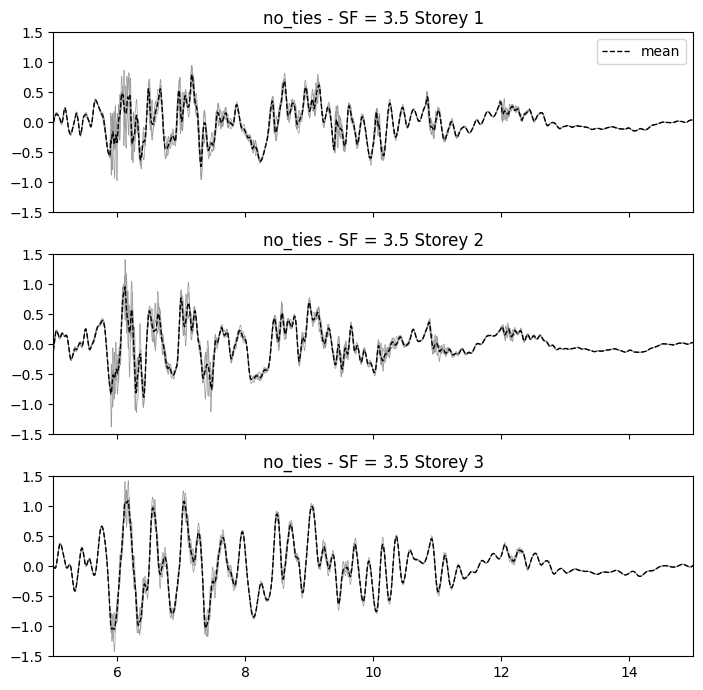

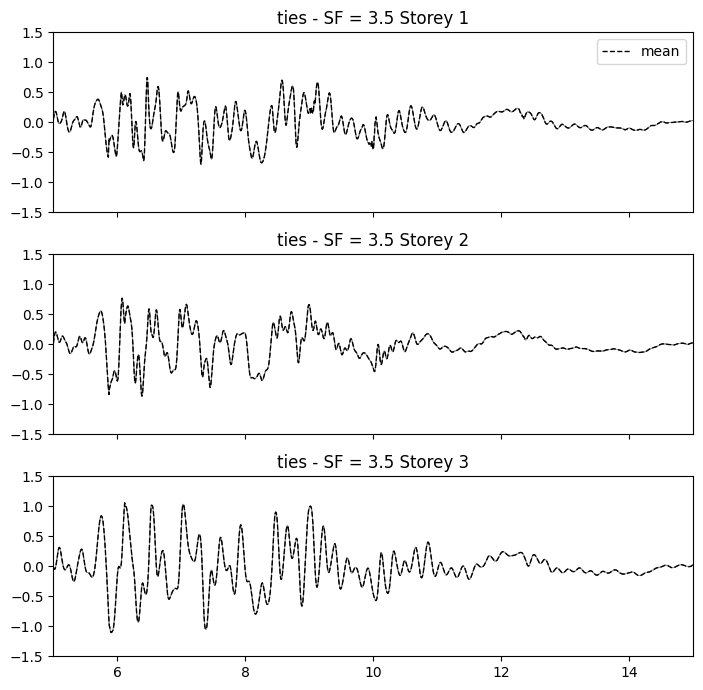

In [13]:
x_min = 5
x_max = 15
y_min = -1.5
y_max = 1.5

for model_tag, mr in model_responses.items():
    for record_tag, rr in mr.items():
        print(f"{model_tag} {record_tag}")
        fig, axs = plt.subplots(3, 1, figsize=(7,7), sharex=True, sharey=True)
        for ii, (storey, storey_accs) in enumerate(rr["acc"].items()):
            for node, acc in storey_accs.items():
                axs[ii].plot(rr["time"], acc / 9810, lw=0.5, color="0.6")
            axs[ii].plot(rr["time"], storey_accs["mean"] / 9810, ls="--", color="k", lw=1.0, label="mean")
            axs[ii].set_title(f"{model_tag} - SF = {record_tag} Storey {storey}")
            axs[ii].set_ylabel
        
        axs[0].legend()
        axs[0].set_xlim(x_min, x_max)
        axs[0].set_ylim(y_min, y_max)

        fig.tight_layout()
        fig.savefig(FIGURE_DST / f"storey_accelerations_{model_tag}_{record_tag}.png", dpi=300)

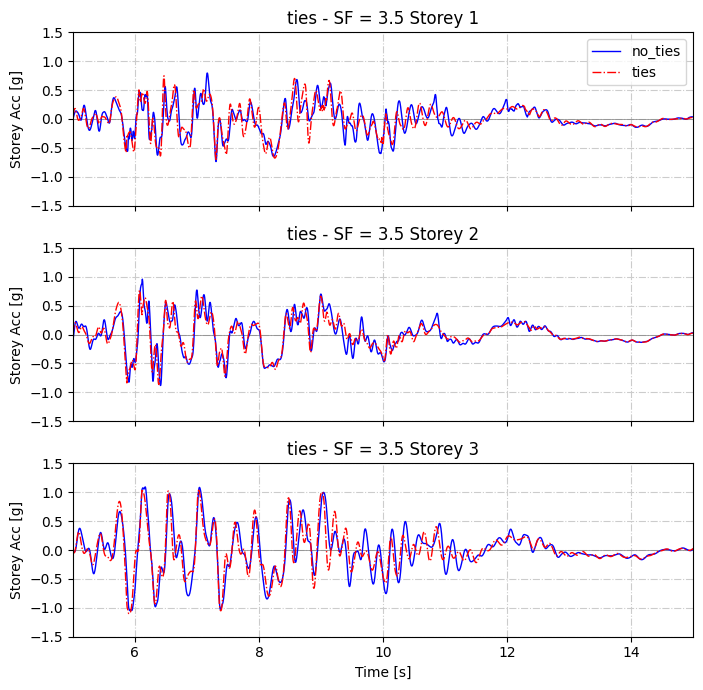

In [27]:
# compare the mean storey accelerations
x_min = 5
x_max = 15
y_min = -1.5
y_max = 1.5

fig, axs = plt.subplots(3, 1, figsize=(7,7), sharex=True, sharey=True)
for ax in axs:
    ax.grid(True, which="major", ls="-.", color="0.8")
    ax.axhline(0, color="0.5", lw=0.5)

for (model_tag, mr), colour, line in zip(model_responses.items(), ["b", "r"], ["-", "-."]):
    for record_tag, rr in mr.items():
        for ii, (storey, storey_accs) in enumerate(rr["acc"].items()):
            axs[ii].plot(rr["time"], storey_accs["mean"] / 9810, lw=1, label=f"{model_tag}", color=colour, ls=line)
            axs[ii].set_title(f"{model_tag} - SF = {record_tag} Storey {storey}")

axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(y_min, y_max)
axs[0].legend()
axs[2].set_xlabel("Time [s]")
for ax in axs:
    ax.set_ylabel("Storey Acc [g]")

fig.tight_layout()
fig.savefig(FIGURE_DST / f"comparison_mean_storey_accelerations.png", dpi=300)

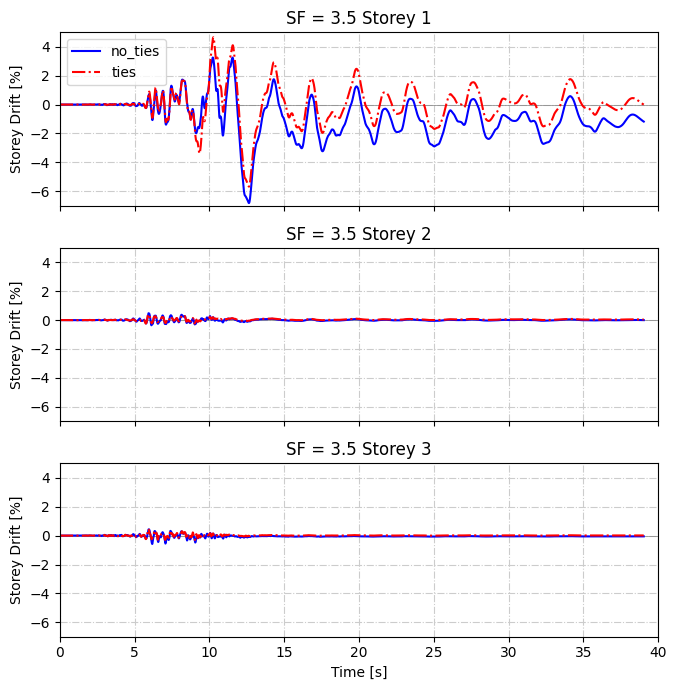

In [32]:
# compare the storey drifts
x_min = 0
x_max = 40
y_min = -7
y_max = 5

fig, axs = plt.subplots(3, 1, figsize=(7,7), sharex=True, sharey=True)
for ax in axs:
    ax.grid(True, which="major", ls="-.", color="0.8")
    ax.axhline(0, color="0.5", lw=0.5)

for (model_tag, mr), colour, line in zip(model_responses.items(), ["b", "r"], ["-", "-."]):
    for record_tag, rr in mr.items():
        for ii, (storey, drift) in enumerate(rr["drift"].items()):
            axs[ii].plot(rr["time"], drift * 100, lw=1.5, label=f"{model_tag}", color=colour, ls=line)
            axs[ii].set_title(f"SF = {record_tag} Storey {storey}")

for ax in axs:
    ax.set_ylabel("Storey Drift [%]")

axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(y_min, y_max)
axs[0].legend()
axs[2].set_xlabel("Time [s]")
fig.tight_layout()
fig.savefig(FIGURE_DST / f"storey_drifts_model_comparison.png", dpi=300)
    

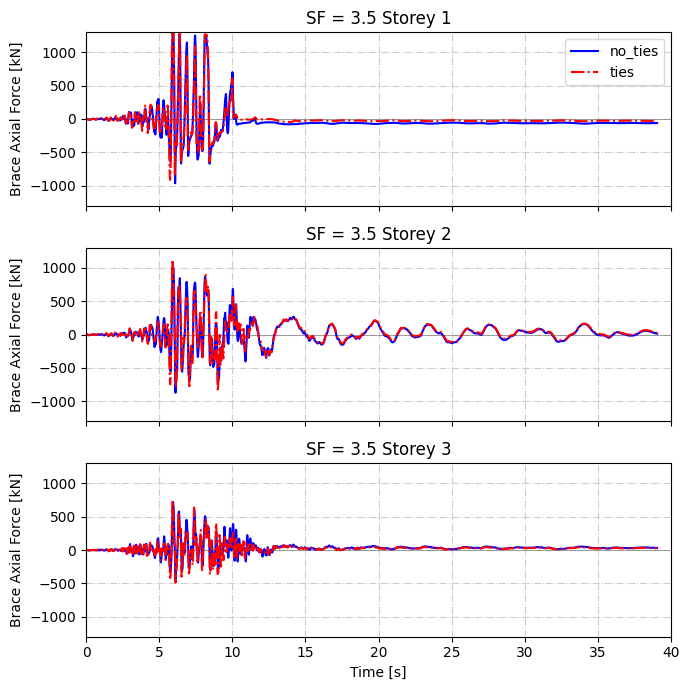

In [31]:
# compare the left brace forces
x_min = 0
x_max = 40
y_min = -1300
y_max = 1300

fig, axs = plt.subplots(3, 1, figsize=(7,7), sharex=True, sharey=True)
for ax in axs:
    ax.grid(True, which="major", ls="-.", color="0.8")
    ax.axhline(0, color="0.5", lw=0.5)

for (model_tag, mr), colour, line in zip(model_responses.items(), ["b", "r"], ["-", "-."]):
    for record_tag, rr in mr.items():
        for ii, (storey, vb) in enumerate(rr["Vb_l"].items()):
            axs[ii].plot(rr["time"], vb / 1000, lw=1.5, label=f"{model_tag}", color=colour, ls=line)
            axs[ii].set_title(f"SF = {record_tag} Storey {storey}")

axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(y_min, y_max)
axs[0].legend()

for ax in axs:
    ax.set_ylabel("Brace Axial Force [kN]")

axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(y_min, y_max)
axs[0].legend()
axs[2].set_xlabel("Time [s]")
fig.tight_layout()
fig.savefig(FIGURE_DST / f"storey_left_brace_force_model_comparison.png", dpi=300)

In [34]:
# compare modal results
modal_results = {}
for model_tag, model_folder in model_folders.items():
    results_folder = ROOT / model_folder / "modal"
    with open(results_folder / "modal_properties.pickle", "rb") as file:
        modal_results[model_tag] = pickle.load(file)

In [36]:
for model_tag, modal in modal_results.items():
    print(model_tag)
    print([round(s, 3) for s in modal["eigenPeriod"]])
    print([round(s, 3) for s in modal["partiMassRatiosMX"]])
    print()

no_ties
[0.388, 0.142, 0.088, 0.086, 0.076, 0.061, 0.048, 0.045, 0.043, 0.042, 0.041, 0.039]
[84.119, 12.11, 0.0, 3.688, 0.0, 0.0, 0.005, 0.029, 0.0, 0.049, 0.0, 0.0]

ties
[0.35, 0.134, 0.083, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0]
[85.917, 11.727, 2.356, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

